# Goal: Build a system to predict fake news

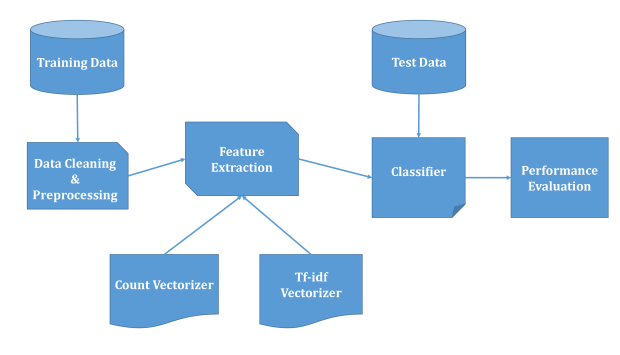

In [1]:
from IPython.display import Image
Image(filename="C:/Users/ranja/Desktop/project/diagram.png")

###### Dataset used - https://www.kaggle.com/

##### Dataset Description

train.csv: A full training dataset with the following attributes:

* id: unique id for a news article
* title: the title of a news article
* author: author of the news article
* text: the text of the article
* label: a label that marks the article as potentially fake/real
  * 1: fake
  * 0: real

test.csv: A testing training dataset with all the same attributes at train.csv without the label.


#### Importing all the required libraries

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.pyplot as plt

import re #Regular expressions 
import nltk #Natural Language Toolkit
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
#from sklearn.linear_model import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import metrics
from prettytable import PrettyTable
import itertools
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


## Data Pre-processing and Analysis

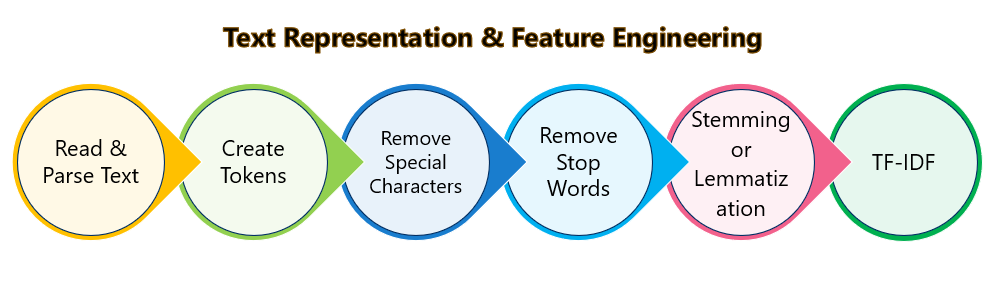

In [3]:
from IPython.display import Image
Image(filename="C:/Users/ranja/Desktop/project/text representation and tokenization.png")

##### Loading and exploratory data analysis : visualize the proportion of real and fake news.

In [4]:
data = pd.read_csv('C:/Users/ranja/Desktop/project/train.csv')
conversion_dict = {0: 'Real', 1: 'Fake'}
data['label'] = data['label'].replace(conversion_dict)
data.label.value_counts()


Fake    10413
Real    10387
Name: label, dtype: int64

In [5]:
import plotly.express as px

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  object
dtypes: int64(1), object(4)
memory usage: 812.6+ KB


In [7]:
data.head()

id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text label  
0  House Dem Aide: We Didn’t Even See Comey’s Let...  Fake  
1  Ever get the feeling your life circles the rou...  Real  
2  Why the Truth Might Get You Fired October 29, ...  Fake  
3  Videos 15 Civilians Killed In Single US Airstr...  Fake  
4  Print \nAn Iranian woman has been sentenced to...  Fake

In [8]:
label = ['Real', 'Fake']
y1 = [10413, 10387]

In [9]:
# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])

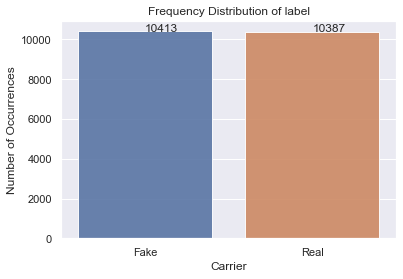

In [10]:
%matplotlib inline
carrier_count = data["label"].value_counts()
sns.set(style="darkgrid")
sns.barplot(carrier_count.index, carrier_count.values, alpha=0.9)
plt.title('Frequency Distribution of label')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Carrier', fontsize=12)
addlabels(label, y1) # calling the function to add lables
plt.show()

In [11]:
type(carrier_count)

pandas.core.series.Series

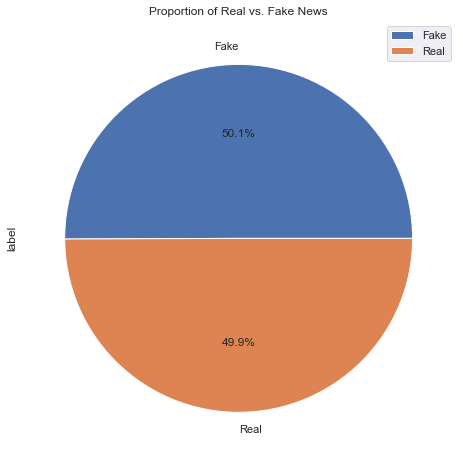

In [12]:
plt.title('Proportion of Real vs. Fake News')
data["label"].value_counts().head(3).plot(kind = 'pie', autopct='%1.1f%%', figsize=(8, 8)).legend()

##### Visualizing top 10 Authors :-

In [13]:
import seaborn as sns 
import matplotlib.pyplot as plt

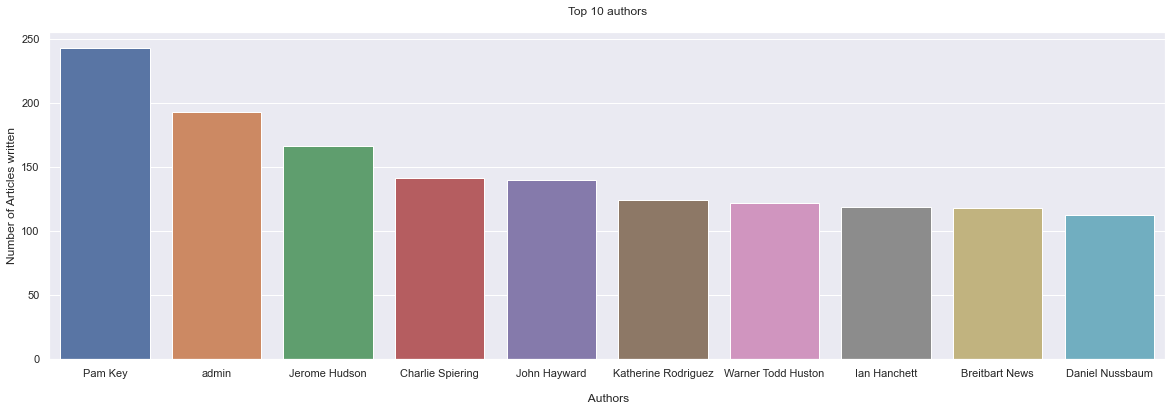

In [14]:
d = data['author'].value_counts().sort_values(ascending=False).head(10)
d = pd.DataFrame(d)
d = d.reset_index() # dataframe with top 5 authors

# Plotting
sns.set()
plt.figure(figsize=(20,6))
sns.barplot(x='index', y='author', data=d)
plt.xlabel("\n Authors")
plt.ylabel("Number of Articles written")
plt.title("Top 10 authors\n")
plt.show()

###### Checking for missing values

In [15]:
data.isnull().sum() # missing values

id           0
title      558
author    1957
text        39
label        0
dtype: int64

###### replacing the null values with empty strings

In [16]:
 #replacing missing values
data = data.fillna('') 
data.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

#### we are using field text description to train our model to help predict if it is real or fake news.

In [17]:
data1 = data.copy()

In [18]:
data1.head()

id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text label  
0  House Dem Aide: We Didn’t Even See Comey’s Let...  Fake  
1  Ever get the feeling your life circles the rou...  Real  
2  Why the Truth Might Get You Fired October 29, ...  Fake  
3  Videos 15 Civilians Killed In Single US Airstr...  Fake  
4  Print \nAn Iranian woman has been sentenced to...  Fake

In [19]:
# Now we will separate the data and label i.e. text corpus and label fields
X = data.drop(columns='label', axis=1)
Y = data['label']

#### securing a copy of dataset

In [51]:
X1 = X.copy()
Y1 =Y.copy()
data1 = data.copy()

In [20]:
X = data['text'].str.lower()
print(X)

0        house dem aide: we didn’t even see comey’s let...
1        ever get the feeling your life circles the rou...
2        why the truth might get you fired october 29, ...
3        videos 15 civilians killed in single us airstr...
4        print \nan iranian woman has been sentenced to...
                               ...                        
20795    rapper t. i. unloaded on black celebrities who...
20796    when the green bay packers lost to the washing...
20797    the macy’s of today grew from the union of sev...
20798    nato, russia to hold parallel exercises in bal...
20799      david swanson is an author, activist, journa...
Name: text, Length: 20800, dtype: object


In [21]:
print(Y)

0        Fake
1        Real
2        Fake
3        Fake
4        Fake
         ... 
20795    Real
20796    Real
20797    Real
20798    Fake
20799    Fake
Name: label, Length: 20800, dtype: object


In [22]:
X.head()

0    house dem aide: we didn’t even see comey’s let...
1    ever get the feeling your life circles the rou...
2    why the truth might get you fired october 29, ...
3    videos 15 civilians killed in single us airstr...
4    print \nan iranian woman has been sentenced to...
Name: text, dtype: object

## processing for wordcloud and ngram

In [23]:
#Sepearting the dataset into the different dataframe based on the label colum

RealNews = data[data['label']=="Real"]
FakeNews = data[data['label']=="Fake"]
print(RealNews.shape)
print(FakeNews.shape)

(10387, 5)
(10413, 5)


In [24]:
stop = stopwords.words('english')

In [195]:
#stop

In [25]:
def tokenizeandstopwords(text):
    tokens = nltk.word_tokenize(text)
    # taken only words (not punctuation)
    token_words = [w for w in tokens if w.isalpha()]
    meaningful_words = [w for w in token_words if not w in stop]
    joined_words = ( " ".join(meaningful_words))
    return joined_words

In [26]:
# import nltk
# nltk.download('punkt')

In [27]:
RealNews['text'] = RealNews['text'].str.lower()
FakeNews['text'] = FakeNews['text'].str.lower()

In [28]:
RealNews['text'] = RealNews['text'].apply(tokenizeandstopwords)
FakeNews['text'] = FakeNews['text'].apply(tokenizeandstopwords)

In [29]:
from wordcloud import WordCloud

In [30]:
def generate_word_cloud(text):
    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        background_color = 'black').generate(str(text))
    fig = plt.figure(
        figsize = (40, 30),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

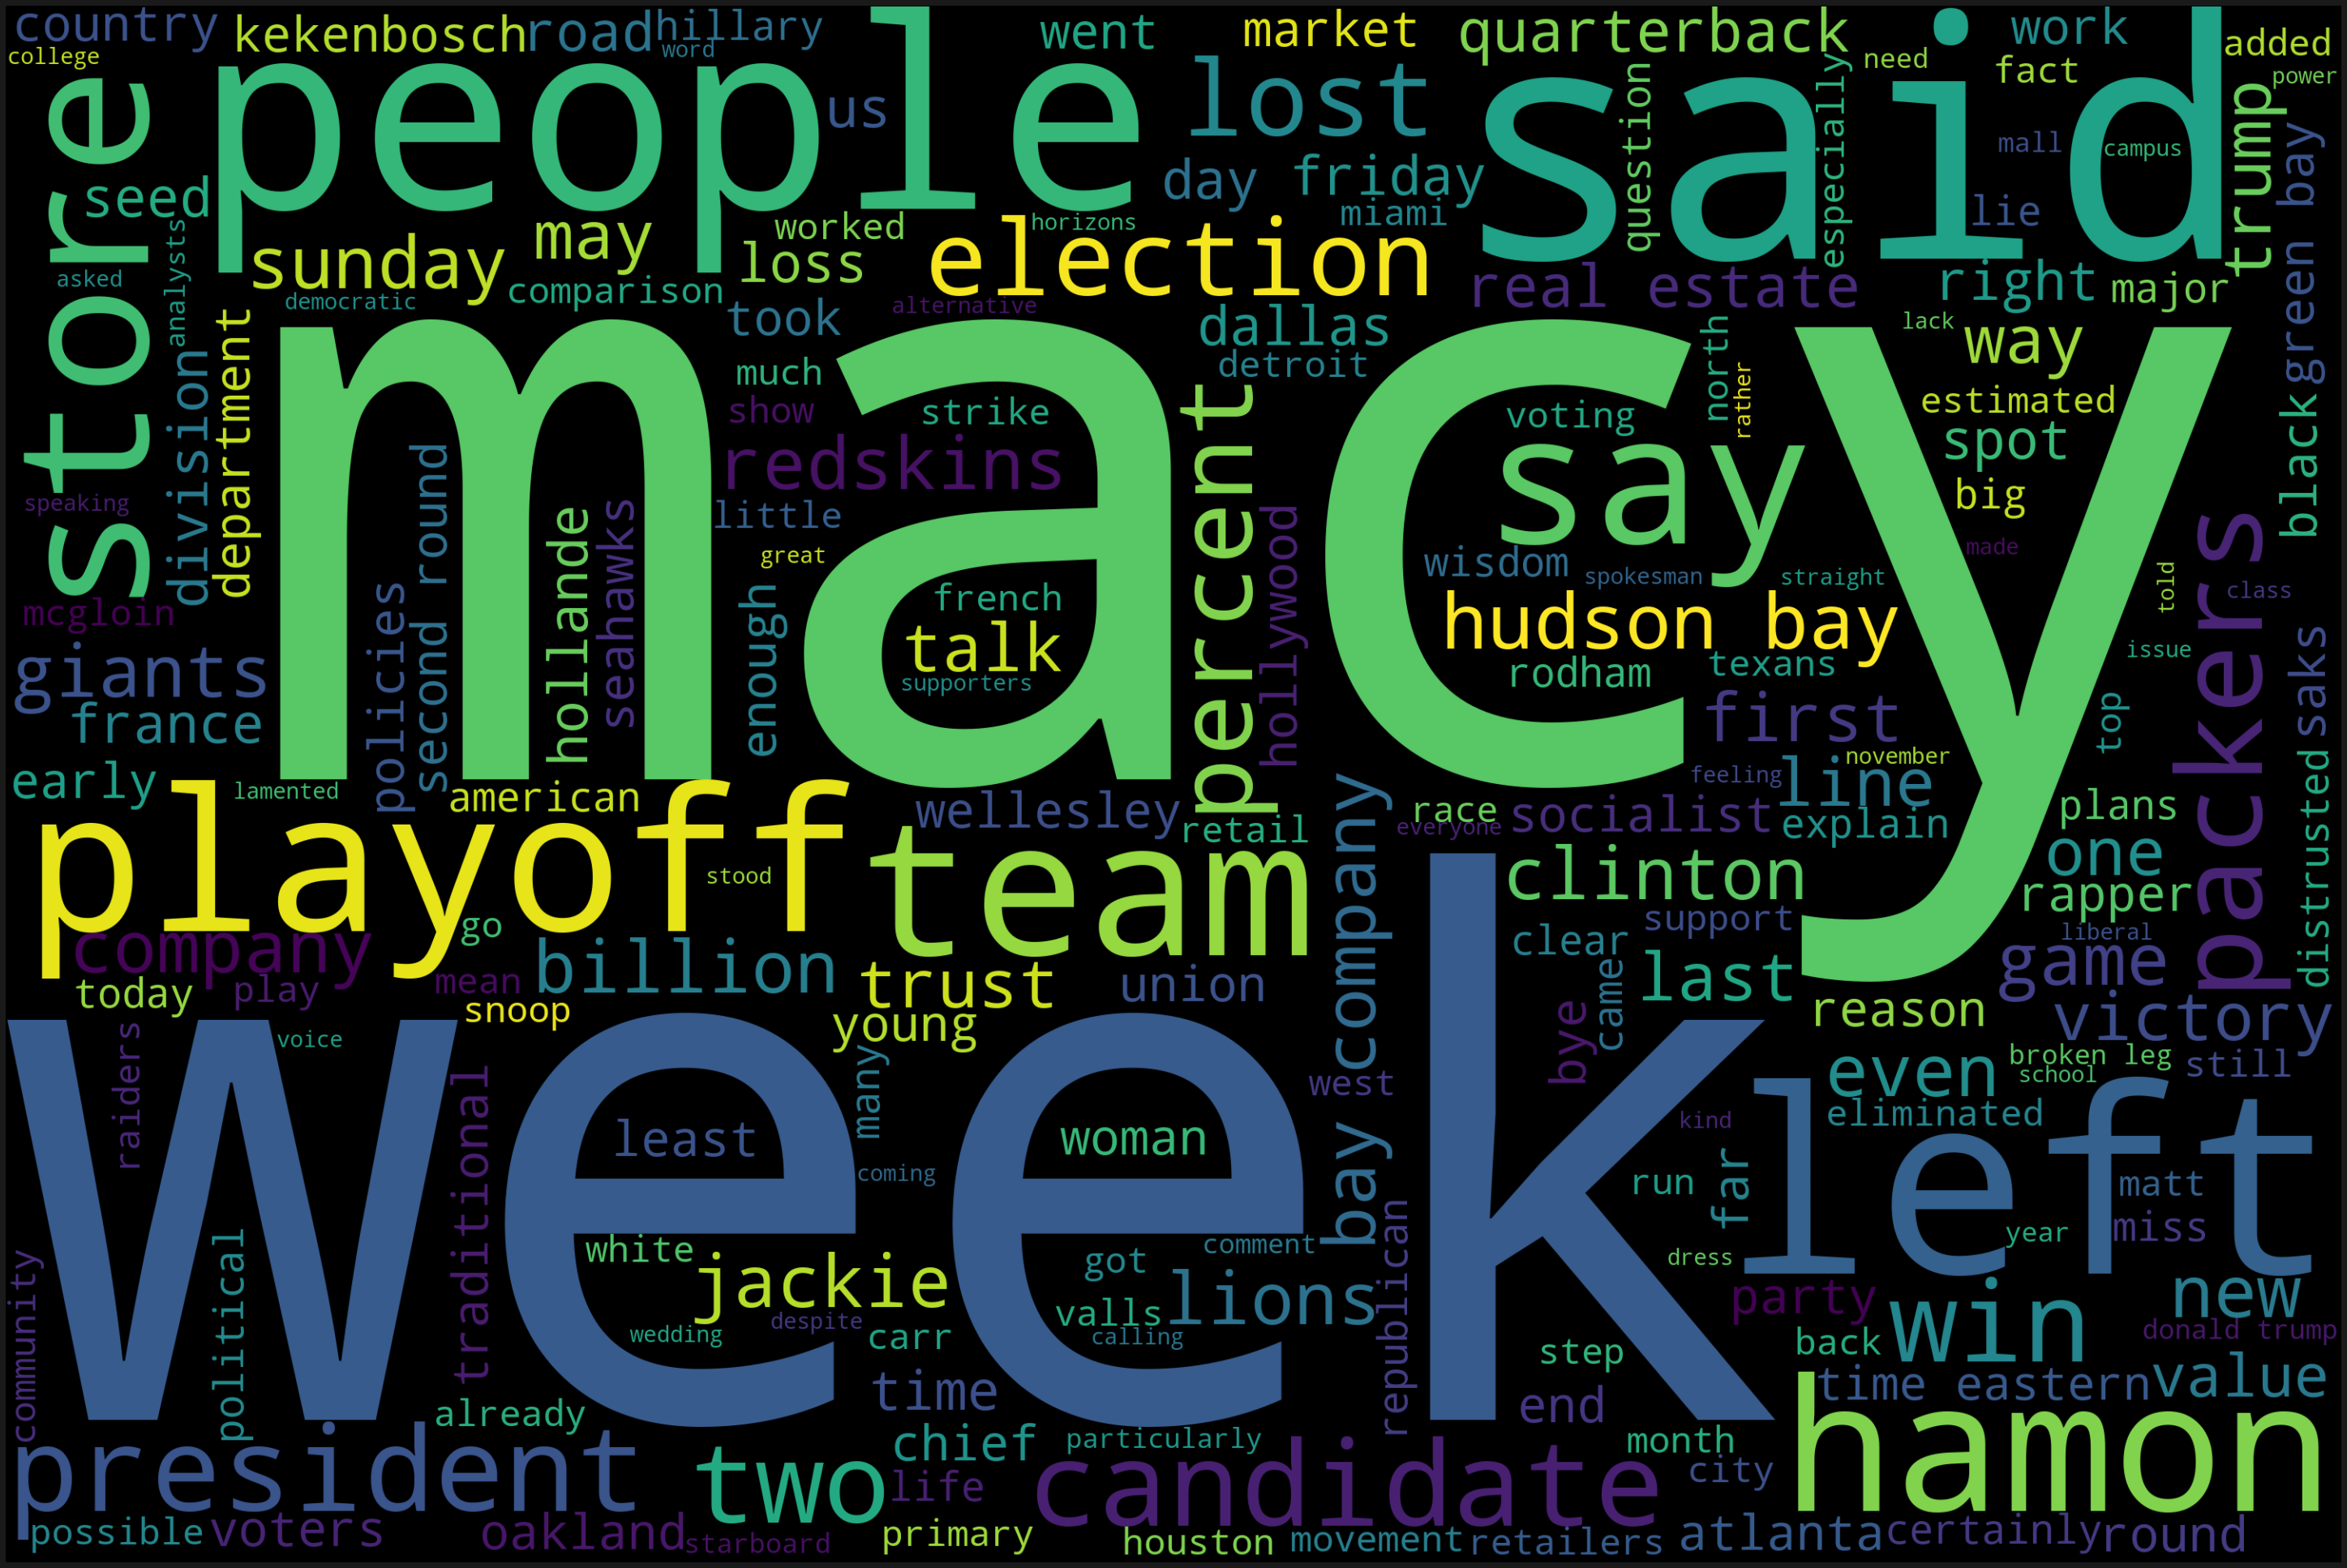

In [31]:
RealNews_text = RealNews.text.values
generate_word_cloud(RealNews_text)

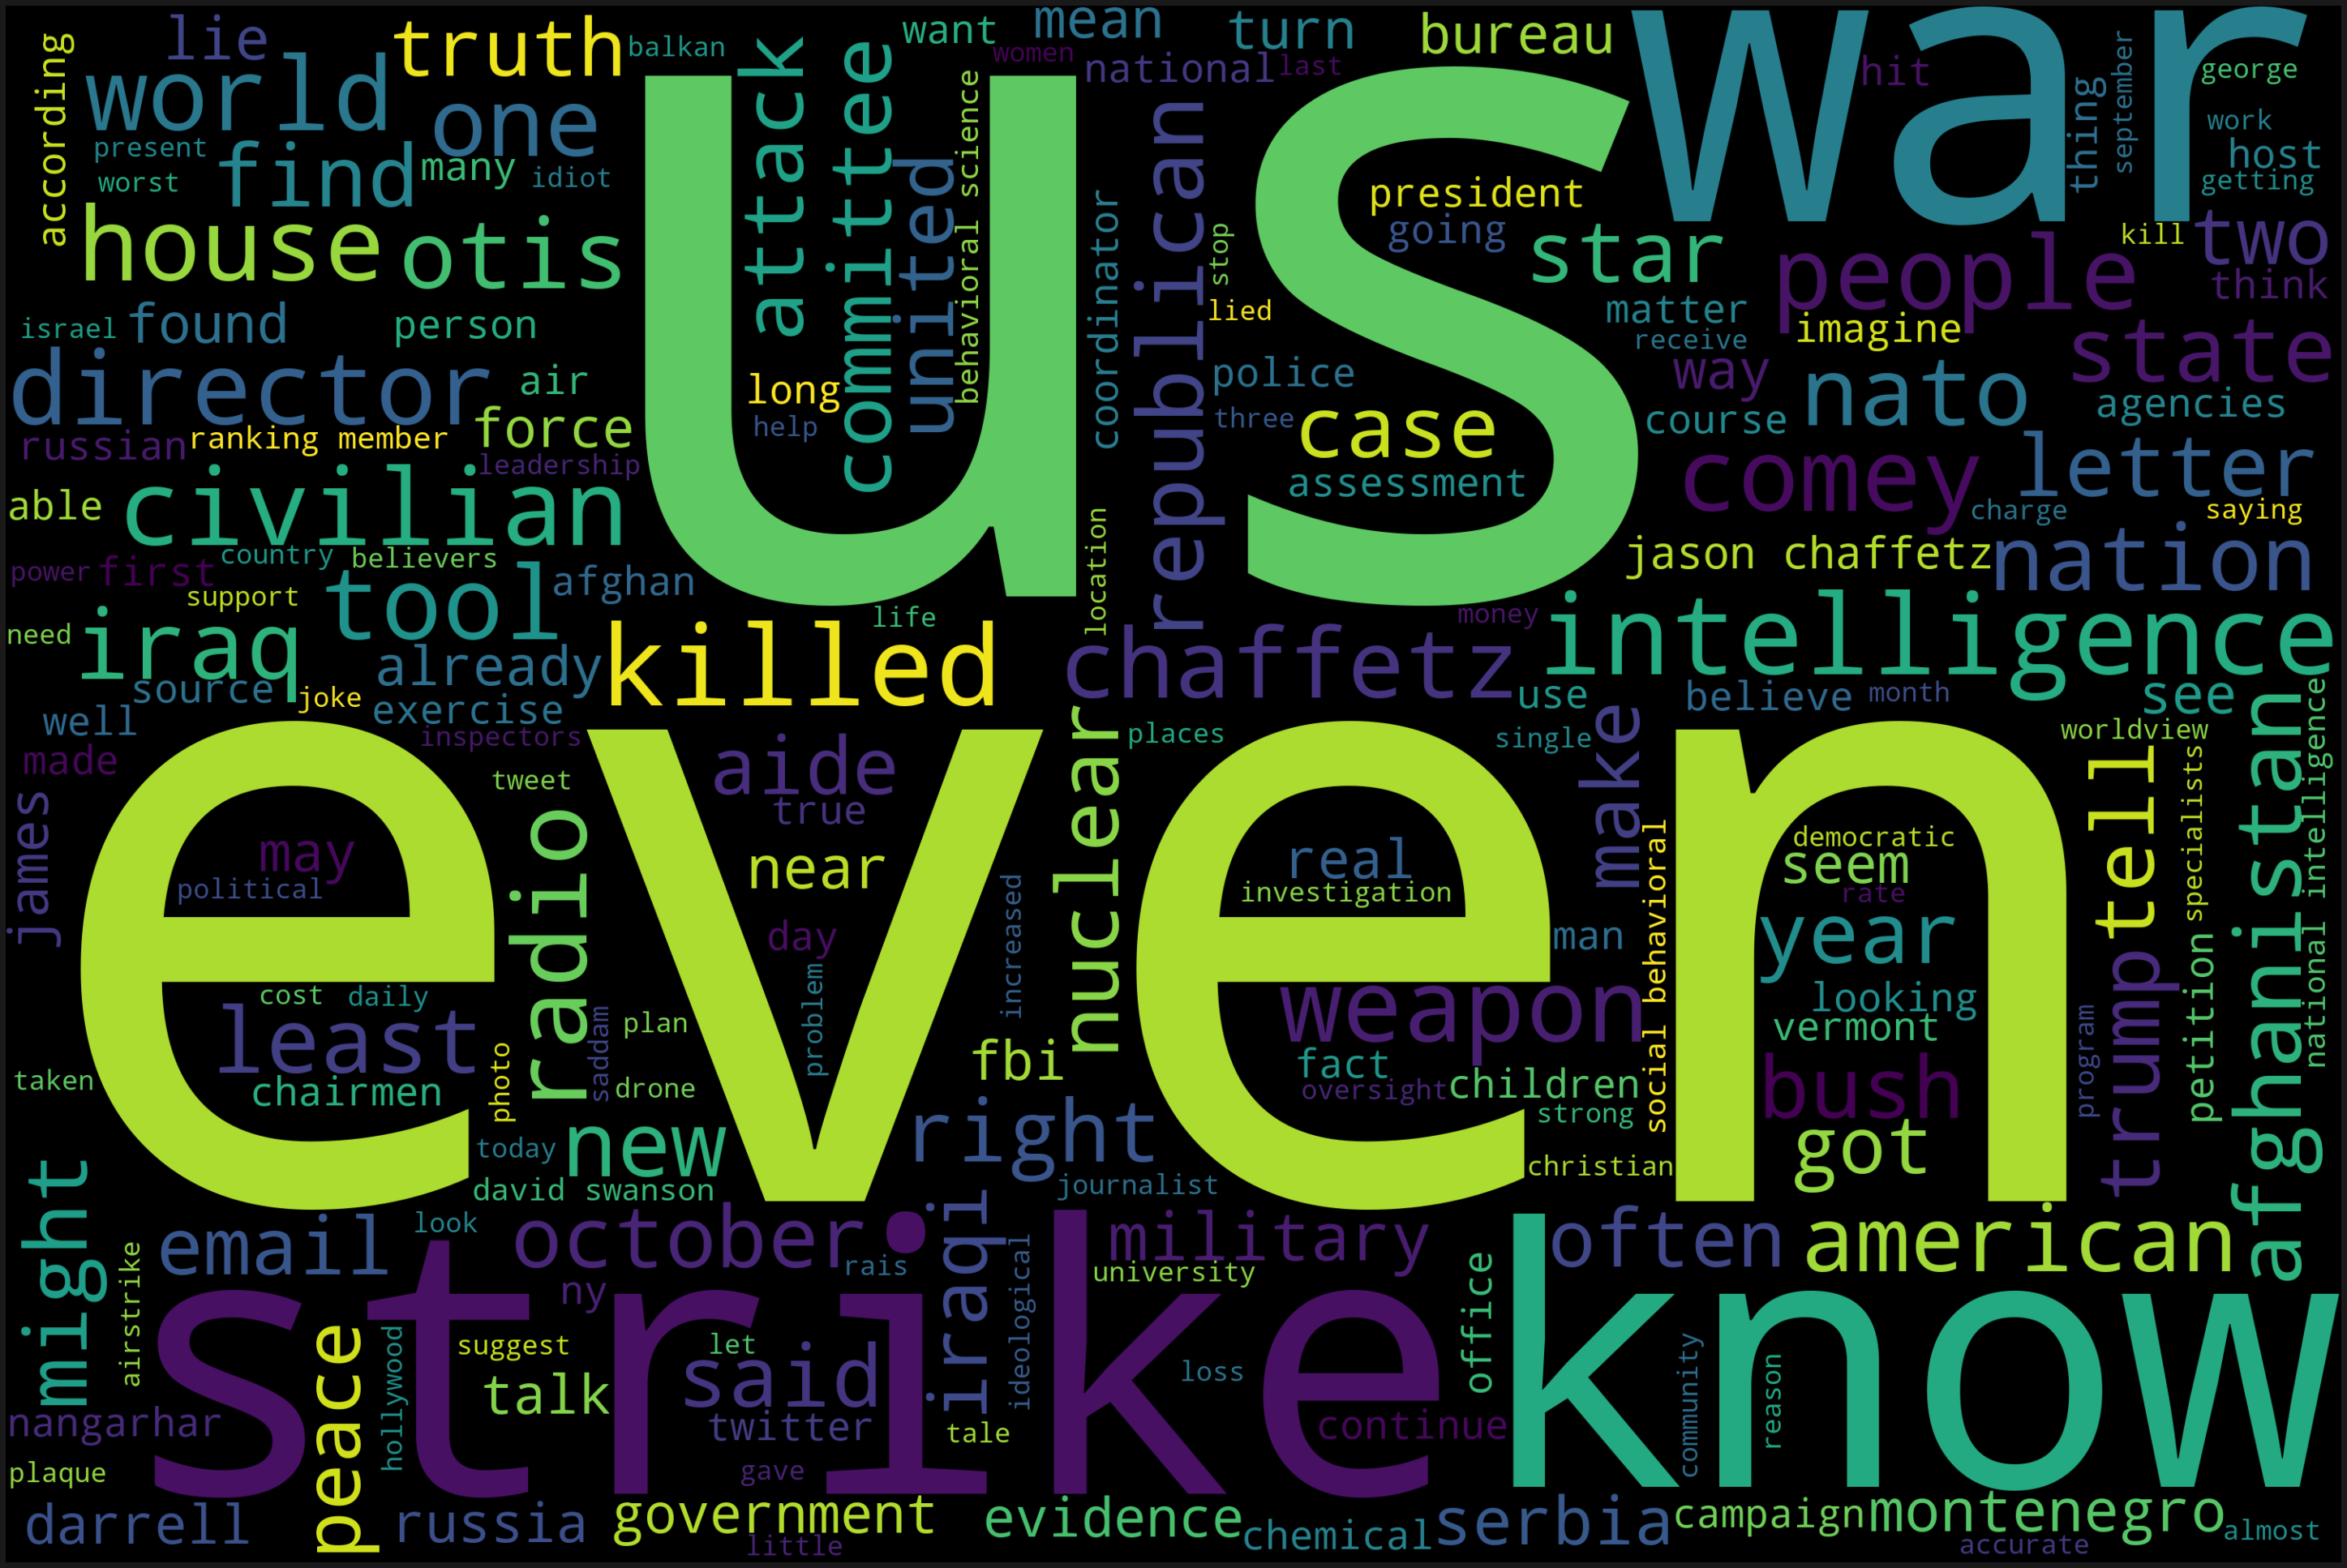

In [32]:
FakeNews_text = FakeNews.text.values
generate_word_cloud(FakeNews_text)

### n-gram analysis

In [33]:
data['text'] = data['text'].str.lower()

In [34]:
data['text'] = data['text'].apply(tokenizeandstopwords)

In [35]:
def basic_clean(text):
#   simple function to clean up the data. All the words that
#   are not designated as a stop word is then lemmatized after
#   encoding and basic regex parsing are performed.
 
  wnl = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('english')
  words = re.sub(r'[^\w\s]', '', text).split()
  return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [36]:
# import nltk
# nltk.download('wordnet')

In [37]:
words = basic_clean(''.join(str(data['text'].tolist())))

In [90]:
words

['house',
 'dem',
 'aide',
 'even',
 'see',
 'comey',
 'letter',
 'jason',
 'chaffetz',
 'tweeted',
 'darrell',
 'lucus',
 'october',
 'subscribe',
 'jason',
 'chaffetz',
 'stump',
 'american',
 'fork',
 'utah',
 'image',
 'courtesy',
 'michael',
 'jolley',
 'available',
 'creative',
 'license',
 'apology',
 'keith',
 'olbermann',
 'doubt',
 'worst',
 'person',
 'world',
 'director',
 'james',
 'comey',
 'according',
 'house',
 'democratic',
 'aide',
 'look',
 'like',
 'also',
 'know',
 'person',
 'well',
 'turn',
 'comey',
 'sent',
 'letter',
 'announcing',
 'fbi',
 'looking',
 'email',
 'may',
 'related',
 'hillary',
 'clinton',
 'email',
 'server',
 'ranking',
 'democrat',
 'relevant',
 'committee',
 'hear',
 'comey',
 'found',
 'via',
 'tweet',
 'one',
 'republican',
 'committee',
 'chairman',
 'know',
 'comey',
 'notified',
 'republican',
 'chairman',
 'democratic',
 'ranking',
 'member',
 'house',
 'intelligence',
 'judiciary',
 'oversight',
 'committee',
 'agency',
 'reviewing',

## unigram

In [40]:
unigrams_series = (pd.Series(nltk.ngrams(words, 1)).value_counts())[:25]

Text(0.5, 0, 'Number of Occurances')

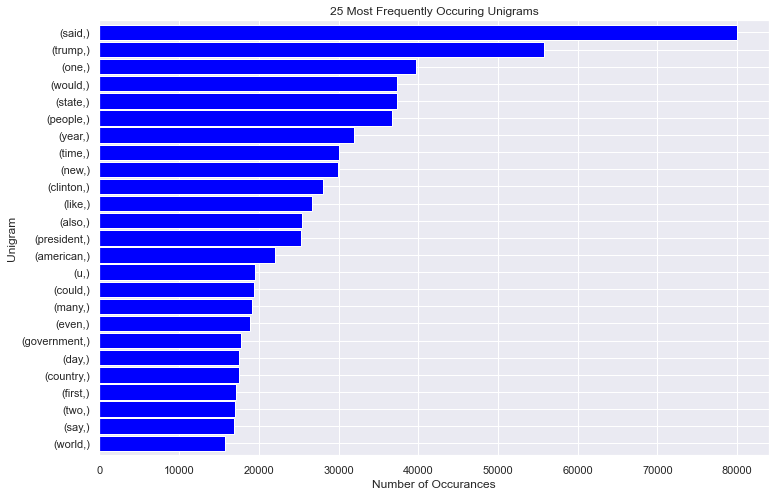

In [44]:
unigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('25 Most Frequently Occuring Unigrams')
plt.ylabel('Unigram')
plt.xlabel('Number of Occurances')

### bigram

In [43]:
bigrams_series = (pd.Series(nltk.ngrams(words, 2)).value_counts())[:25]

Text(0.5, 0, 'Number of Occurances')

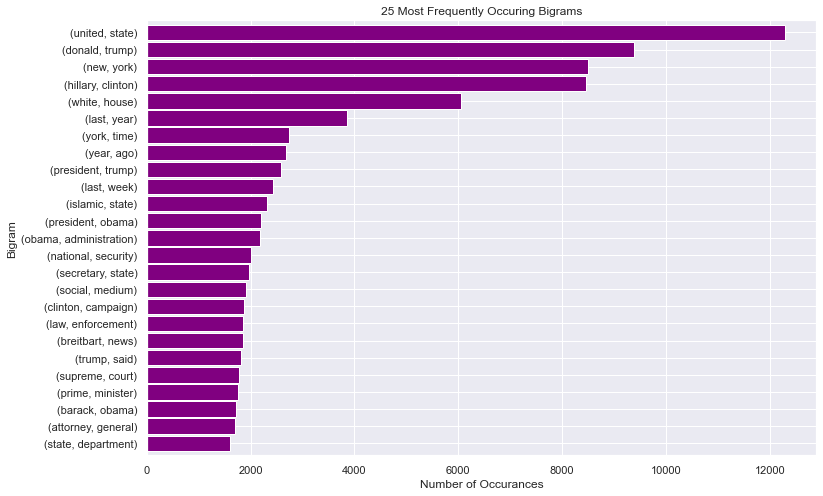

In [45]:
bigrams_series.sort_values().plot.barh(color='purple', width=.9, figsize=(12, 8))
plt.title('25 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('Number of Occurances')

### Trigram

In [46]:
trigrams_series = (pd.Series(nltk.ngrams(words, 3)).value_counts())[:25]

Text(0.5, 0, '# of Occurances')

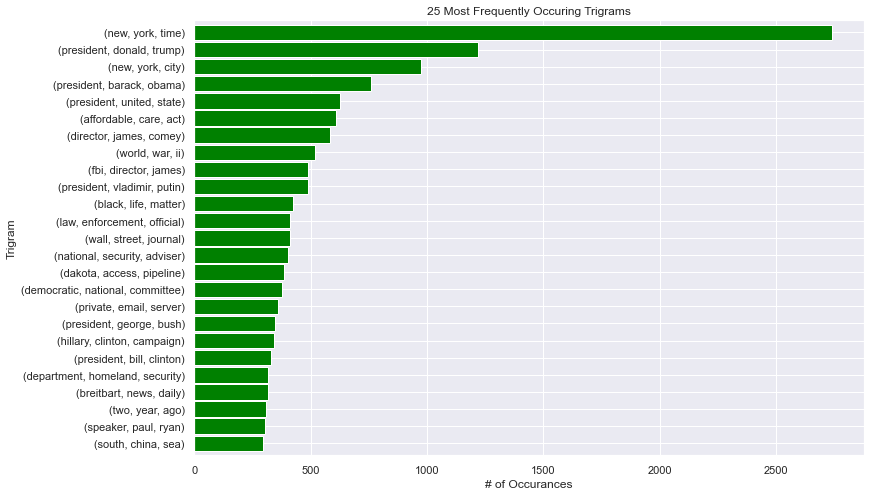

In [47]:
trigrams_series.sort_values().plot.barh(color='green', width=.9, figsize=(12, 8))
plt.title('25 Most Frequently Occuring Trigrams')
plt.ylabel('Trigram')
plt.xlabel('# of Occurances')

### removing special characters, stopwords, applying Stemming & Tf-IDF

In [48]:
data.head()

id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text label  
0  house dem aide even see comey letter jason cha...  Fake  
1  ever get feeling life circles roundabout rathe...  Real  
2  truth might get fired october tension intellig...  Fake  
3  videos civilians killed single us airstrike id...  Fake  
4  print iranian woman sentenced six years prison...  Fake

In [ ]:
words

In [49]:
X.head()

0    house dem aide: we didn’t even see comey’s let...
1    ever get the feeling your life circles the rou...
2    why the truth might get you fired october 29, ...
3    videos 15 civilians killed in single us airstr...
4    print \nan iranian woman has been sentenced to...
Name: text, dtype: object

In [50]:
Y.head()

0    Fake
1    Real
2    Fake
3    Fake
4    Fake
Name: label, dtype: object

In [52]:
ps = PorterStemmer()

def stemming(corpus):
    # Pick all alphabet characters - lowercase and uppercase...all others such as numbers and punctuations will be removed. Numbers or punctuations will be replaced by a whitespace
    stemmed_corpus = re.sub('[^a-zA-Z]',' ',corpus)
    
    # Converting all letters to lowercase 
    stemmed_corpus = stemmed_corpus.lower()
    
    # Converting all to a splitted case or a list
    stemmed_corpus = stemmed_corpus.split()
    
    # Applying stemming, so we get the root words wherever possible + remove stopwords as well
    stemmed_corpus = [ps.stem(word) for word in stemmed_corpus] #if not word in stopwords.words('english')]
    
    # Join all the words in final content
    stemmed_corpus = ' '.join(stemmed_corpus)
    return stemmed_corpus

In [71]:
X = data['text']
print(X)

X.head()

0        hous dem aid even see comey letter jason chaff...
1        ever get feel life circl roundabout rather hea...
2        truth might get fire octob tension intellig an...
3        video civilian kill singl us airstrik identifi...
4        print iranian woman sentenc six year prison ir...
                               ...                        
20795    rapper unload black celebr met donald trump el...
20796    green bay packer lost washington redskin week ...
20797    maci today grew union sever great name america...
20798    nato russia hold parallel exercis balkan press...
20799    david swanson author activist journalist radio...
Name: text, Length: 20800, dtype: object


In [54]:
data['text'] = data['text'].apply(stemming)

In [72]:
print(data['text'])

X.head()

0        hous dem aid even see comey letter jason chaff...
1        ever get feel life circl roundabout rather hea...
2        truth might get fire octob tension intellig an...
3        video civilian kill singl us airstrik identifi...
4        print iranian woman sentenc six year prison ir...
                               ...                        
20795    rapper unload black celebr met donald trump el...
20796    green bay packer lost washington redskin week ...
20797    maci today grew union sever great name america...
20798    nato russia hold parallel exercis balkan press...
20799    david swanson author activist journalist radio...
Name: text, Length: 20800, dtype: object


In [56]:
type(data['text'])

pandas.core.series.Series

In [ ]:
# Separating data and label
# X = data1['text'].values
# Y = data1['label'].values

In [62]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [60]:
doc = CountVectorizer()
word_count=doc.fit_transform(words)
word_count.shape
print(word_count)

  (0, 54721)	1
  (1, 29444)	1
  (2, 2449)	1
  (3, 39379)	1
  (4, 106076)	1
  (5, 22849)	1
  (6, 68261)	1
  (7, 60726)	1
  (8, 19587)	1
  (9, 122505)	1
  (10, 28017)	1
  (11, 70370)	1
  (12, 83954)	1
  (13, 114423)	1
  (14, 60726)	1
  (15, 19587)	1
  (16, 114114)	1
  (17, 4135)	1
  (18, 43741)	1
  (19, 125483)	1
  (20, 56388)	1
  (21, 25681)	1
  (22, 75503)	1
  (23, 61683)	1
  (24, 8554)	1
  :	:
  (8460423, 31739)	1
  (8460424, 17665)	1
  (8460425, 24933)	1
  (8460426, 115789)	1
  (8460427, 14447)	1
  (8460428, 57152)	1
  (8460429, 128900)	1
  (8460430, 68652)	1
  (8460431, 13678)	1
  (8460432, 54628)	1
  (8460433, 116775)	1
  (8460434, 80392)	1
  (8460435, 96284)	1
  (8460436, 82068)	1
  (8460437, 88415)	1
  (8460438, 93599)	1
  (8460439, 82215)	1
  (8460440, 43410)	1
  (8460441, 122570)	1
  (8460442, 28188)	1
  (8460443, 40553)	1
  (8460444, 52696)	1
  (8460445, 115347)	1
  (8460446, 21759)	1
  (8460447, 54863)	1


###  top 20 most common terms occurences


In [65]:
occ = np.asarray(word_count.sum(axis=0)).ravel().tolist()
counts_df = pd.DataFrame({'term': doc.get_feature_names(), 'occurrences': occ})
counts_df.sort_values(by='occurrences', ascending=False).head(20)

term  occurrences
103509        said        80003
121804       trump        55759
84767          one        39678
131475       would        37344
112879       state        37291
88866       people        36738
132363        year        31892
119496        time        30086
81333          new        29968
21824      clinton        28024
68818         like        26608
3709          also        25424
93122    president        25344
4135      american        22033
25498        could        19408
72329         many        19195
39379         even        18870
48837   government        17717
28266          day        17515
25631      country        17481

In [63]:
#TF-IDF
transformer = TfidfTransformer()
transformed_weights = transformer.fit_transform(word_count)
transformed_weights

<8460448x158235 sparse matrix of type '<class 'numpy.float64'>'
	with 8424097 stored elements in Compressed Sparse Row format>

### top 20 terms by average tf-idf weight

In [64]:
weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': doc.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(20)

term    weight
103509        said  0.009456
121804       trump  0.006591
84767          one  0.004690
131475       would  0.004414
112879       state  0.004408
88866       people  0.004342
132363        year  0.003770
119496        time  0.003556
81333          new  0.003542
21824      clinton  0.003312
68818         like  0.003145
3709          also  0.003005
93122    president  0.002996
4135      american  0.002604
25498        could  0.002294
72329         many  0.002269
39379         even  0.002230
48837   government  0.002094
28266          day  0.002070
25631      country  0.002066

In [73]:
#type(transformed_weights)
X= data['text']
type(X)

pandas.core.series.Series

In [75]:
#TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
vectorizer.fit(X)
X = vectorizer.transform(X)

### Modeling & Model Evaluation

In [76]:
#Splitting the data into test and train datasets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=124)

#### Training  Model1 : Passive Aggressive Classiifier

In [77]:
from sklearn.linear_model import PassiveAggressiveClassifier

model1 = PassiveAggressiveClassifier(max_iter=50)
model1.fit(X_train, Y_train)

# from sklearn.naive_bayes import MultinomialNB
# classifier=MultinomialNB()
# classifier.fit(X, Y)
#print("Accuracy score on the test data:  %0.3f" %test_data_accuracy)

X_train_prediction1 = model1.predict(X_train)
training_data_accuracy1 = accuracy_score(X_train_prediction1, Y_train)

print("Accuracy score on the training data:  %0.3f" %training_data_accuracy1)

# Accuracy Score on Test Data
X_test_prediction1 = model1.predict(X_test)
test_data_accuracy1 = accuracy_score(X_test_prediction1, Y_test)

print("Accuracy score on the test data:  %0.3f" %test_data_accuracy1)

Accuracy score on the training data:  1.000
Accuracy score on the test data:  0.941


###### Function to plot confusion Matrix :-



confusion matrix


[[2903  195]
 [ 174 2968]]




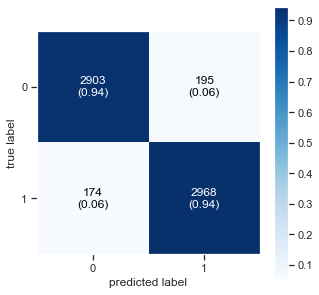

In [78]:
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix


print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(Y_test, X_test_prediction1)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(5, 5),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

### Passive Aggressive Classiifier

In [79]:
# Classification report 
print(classification_report(Y_test, X_test_prediction1))

              precision    recall  f1-score   support

        Fake       0.94      0.94      0.94      3098
        Real       0.94      0.94      0.94      3142

    accuracy                           0.94      6240
   macro avg       0.94      0.94      0.94      6240
weighted avg       0.94      0.94      0.94      6240



#### Training  Model2 : Multinomial Naive Bayes

In [80]:
from sklearn.naive_bayes import MultinomialNB

model2 = MultinomialNB()
model2.fit(X_train, Y_train)
X_train_prediction2 = model2.predict(X_train)
training_data_accuracy2 = accuracy_score(X_train_prediction2, Y_train)

print("Accuracy score on the training data:  %0.3f" %training_data_accuracy2)

# Accuracy Score on Test Data
X_test_prediction2 = model1.predict(X_test)
test_data_accuracy2 = accuracy_score(X_test_prediction2, Y_test)

print("Accuracy score on the test data:  %0.3f" %test_data_accuracy2)

Accuracy score on the training data:  0.897
Accuracy score on the test data:  0.941




confusion matrix


[[2903  195]
 [ 174 2968]]




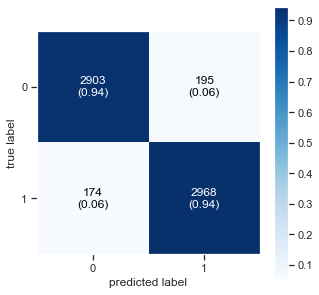

In [81]:
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix


print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(Y_test, X_test_prediction2)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(5, 5),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [82]:
# Classification report for test data
print(classification_report(Y_test, X_test_prediction2))

              precision    recall  f1-score   support

        Fake       0.94      0.94      0.94      3098
        Real       0.94      0.94      0.94      3142

    accuracy                           0.94      6240
   macro avg       0.94      0.94      0.94      6240
weighted avg       0.94      0.94      0.94      6240



#### Training  Model3 : Logistic Regression

In [83]:
#Logistic Regression model
from sklearn.linear_model import LogisticRegression
model3 = LogisticRegression()
model3.fit(X_train, Y_train)

X_train_prediction3 = model3.predict(X_train)
training_data_accuracy3 = accuracy_score(X_train_prediction3, Y_train)

print("Accuracy score on the training data:  %0.3f" %training_data_accuracy3)

# Accuracy Score on Test Data
X_test_prediction3 = model3.predict(X_test)
test_data_accuracy3 = accuracy_score(X_test_prediction3, Y_test)

print("Accuracy score on the test data:  %0.3f" %test_data_accuracy3)

Accuracy score on the training data:  0.960
Accuracy score on the test data:  0.934




confusion matrix


[[2907  191]
 [ 219 2923]]




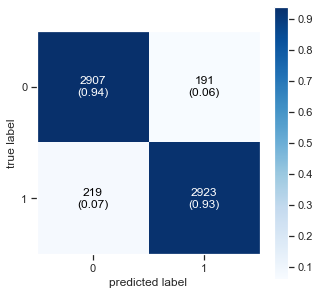

In [84]:
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix


print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(Y_test, X_test_prediction3)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(5, 5),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [85]:
# Classification report for test data
print(classification_report(Y_test, X_test_prediction3))

              precision    recall  f1-score   support

        Fake       0.93      0.94      0.93      3098
        Real       0.94      0.93      0.93      3142

    accuracy                           0.93      6240
   macro avg       0.93      0.93      0.93      6240
weighted avg       0.93      0.93      0.93      6240



#### Training Model4 : Random Forest

In [86]:
from sklearn.ensemble import RandomForestClassifier
model4 = RandomForestClassifier ()
model4.fit(X_train, Y_train)

X_train_prediction4 = model4.predict(X_train)
training_data_accuracy4 = accuracy_score(X_train_prediction4, Y_train)

print("Accuracy score on the training data:  %0.3f" %training_data_accuracy4)

# Accuracy Score on Test Data
X_test_prediction4 = model4.predict(X_test)
test_data_accuracy4 = accuracy_score(X_test_prediction4, Y_test)

print("Accuracy score on the test data:  %0.3f" %test_data_accuracy4)

Accuracy score on the training data:  1.000
Accuracy score on the test data:  0.904




confusion matrix


[[2719  379]
 [ 219 2923]]




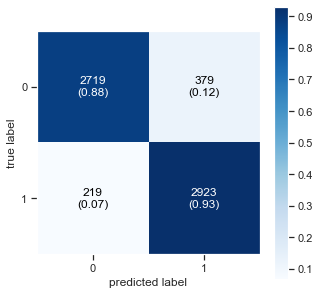

In [87]:
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix


print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(Y_test, X_test_prediction4)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(5, 5),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [88]:
# Classification report for test data
print(classification_report(Y_test, X_test_prediction4))

              precision    recall  f1-score   support

        Fake       0.93      0.88      0.90      3098
        Real       0.89      0.93      0.91      3142

    accuracy                           0.90      6240
   macro avg       0.91      0.90      0.90      6240
weighted avg       0.91      0.90      0.90      6240



#### Training Model5 : Support Vector Machine

In [89]:
from sklearn import svm
model5 = svm.SVC()
model5.fit(X_train, Y_train)

X_train_prediction5 = model5.predict(X_train)
training_data_accuracy5 = accuracy_score(X_train_prediction5, Y_train)

print("Accuracy score on the training data:  %0.3f" %training_data_accuracy5)

# Accuracy Score on Test Data
X_test_prediction5 = model5.predict(X_test)
test_data_accuracy5 = accuracy_score(X_test_prediction5, Y_test)

print("Accuracy score on the test data:  %0.3f" %test_data_accuracy5)

Accuracy score on the training data:  0.997
Accuracy score on the test data:  0.946




confusion matrix


[[2930  168]
 [ 169 2973]]




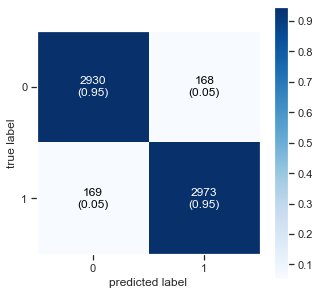

In [91]:
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix


print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(Y_test, X_test_prediction5)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(5, 5),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

### Support Vector Machine

In [92]:
# Classification report for test data
print(classification_report(Y_test, X_test_prediction5))

              precision    recall  f1-score   support

        Fake       0.95      0.95      0.95      3098
        Real       0.95      0.95      0.95      3142

    accuracy                           0.95      6240
   macro avg       0.95      0.95      0.95      6240
weighted avg       0.95      0.95      0.95      6240



##### Comparison of all algorithms Results

In [93]:
from prettytable import PrettyTable
x = PrettyTable()
print('\n')
print("Comparison of all algorithm results")
x.field_names = ["Model", "Accuracy on Test data"]


x.add_row(["Passive Aggressive Classiifier", round(test_data_accuracy1,2)])
x.add_row(["Naive Bayes Algorithm", round(test_data_accuracy2,2)])
x.add_row(["LogisticRegression Algorithm", round(test_data_accuracy3,2)])
x.add_row(["Random Forest Algorithm", round(test_data_accuracy4,2)])
x.add_row(["Support Vector Machine", round(test_data_accuracy5,2)])

print(x)
print('\n')



Comparison of all algorithm results
+--------------------------------+-----------------------+
|             Model              | Accuracy on Test data |
+--------------------------------+-----------------------+
| Passive Aggressive Classiifier |          0.94         |
|     Naive Bayes Algorithm      |          0.94         |
|  LogisticRegression Algorithm  |          0.93         |
|    Random Forest Algorithm     |          0.9          |
|     Support Vector Machine     |          0.95         |
+--------------------------------+-----------------------+




# Making a Prediction

In [170]:
import pandas as pd
test=pd.read_csv("C:/Users/ranja/Desktop/PROJECT1/testing.csv")

In [171]:
test.head()

id                                              title  \
0  20800  Specter of Trump Loosens Tongues, if Not Purse...   
1  20801  Russian warships ready to strike terrorists ne...   
2  20802  #NoDAPL: Native American Leaders Vow to Stay A...   
3  20803  Tim Tebow Will Attempt Another Comeback, This ...   
4  20804                    Keiser Report: Meme Wars (E995)   

                    author                                               text  
0         David Streitfeld  PALO ALTO, Calif.  —   After years of scorning...  
1                      NaN  Russian warships ready to strike terrorists ne...  
2            Common Dreams  Videos #NoDAPL: Native American Leaders Vow to...  
3            Daniel Victor  If at first you don’t succeed, try a different...  
4  Truth Broadcast Network  42 mins ago 1 Views 0 Comments 0 Likes 'For th...

In [172]:
test2=test.copy()
test.isnull().sum()

id          0
title     122
author    503
text        7
dtype: int64

In [173]:
 #replacing missing values
#test = test.fillna('') 
test=test.dropna()
#since null value rows are dropped indexes needs to be reset
test1=test.copy()
test1.reset_index(inplace=True)
test1.isnull().sum()

index     0
id        0
title     0
author    0
text      0
dtype: int64

In [174]:
ps = PorterStemmer()

def stemming(corpus):
    # Pick all alphabet characters - lowercase and uppercase...all others such as numbers and punctuations will be removed. Numbers or punctuations will be replaced by a whitespace
    stemmed_corpus = re.sub('[^a-zA-Z]',' ',corpus)
    
    # Converting all letters to lowercase 
    stemmed_corpus = stemmed_corpus.lower()
    
    # Converting all to a splitted case or a list
    stemmed_corpus = stemmed_corpus.split()
    
    # Applying stemming, so we get the root words wherever possible + remove stopwords as well
    stemmed_corpus = [ps.stem(word) for word in stemmed_corpus] #if not word in stopwords.words('english')]
    
    # Join all the words in final content
    stemmed_corpus = ' '.join(stemmed_corpus)
    return stemmed_corpus

In [175]:
test1['text'] = test1['text'].apply(stemming)

In [176]:
X0 = test1['text']
print(X0)

0       palo alto calif after year of scorn the polit ...
1       video nodapl nativ american leader vow to stay...
2       if at first you don t succeed tri a differ spo...
3       min ago view comment like for the first time i...
4       sunday on nbc s meet the press hous minor lead...
                              ...                        
4570    pre trump on if tape exist of hi convers with ...
4571    of all the dysfunct that plagu the world s meg...
4572    washington gov john kasich of ohio on tuesday ...
4573    good morn want to get california today by emai...
4574    perhap you ve seen the new tv seri whose pilot...
Name: text, Length: 4575, dtype: object


In [177]:
#TF-IDF
vectorizer1 = TfidfVectorizer(stop_words='english')
vectorizer1.fit(X0)
X0 = vectorizer.transform(X0)

In [178]:
type(X0)

scipy.sparse.csr.csr_matrix

#### PREDICTION WITH MODEL4 with a test file as input : SVC

In [179]:
pred4=model4.predict(X0)

In [180]:
test=pd.read_csv('C:/Users/ranja/Desktop/PROJECT1/testing.csv')

In [188]:
test1.head()

index     id                                              title  \
0      0  20800  Specter of Trump Loosens Tongues, if Not Purse...   
1      2  20802  #NoDAPL: Native American Leaders Vow to Stay A...   
2      3  20803  Tim Tebow Will Attempt Another Comeback, This ...   
3      4  20804                    Keiser Report: Meme Wars (E995)   
4      6  20806  Pelosi Calls for FBI Investigation to Find Out...   

                    author                                               text  
0         David Streitfeld  palo alto calif after year of scorn the polit ...  
1            Common Dreams  video nodapl nativ american leader vow to stay...  
2            Daniel Victor  if at first you don t succeed tri a differ spo...  
3  Truth Broadcast Network  min ago view comment like for the first time i...  
4                  Pam Key  sunday on nbc s meet the press hous minor lead...

#### input test file header

In [181]:
test.head()

index     id                                              title  \
0      0  20800  Specter of Trump Loosens Tongues, if Not Purse...   
1      2  20802  #NoDAPL: Native American Leaders Vow to Stay A...   
2      3  20803  Tim Tebow Will Attempt Another Comeback, This ...   
3      4  20804                    Keiser Report: Meme Wars (E995)   
4      6  20806  Pelosi Calls for FBI Investigation to Find Out...   

                    author                                               text  
0         David Streitfeld  palo alto calif after year of scorn the polit ...  
1            Common Dreams  video nodapl nativ american leader vow to stay...  
2            Daniel Victor  if at first you don t succeed tri a differ spo...  
3  Truth Broadcast Network  min ago view comment like for the first time i...  
4                  Pam Key  sunday on nbc s meet the press hous minor lead...

In [182]:
test1.info

<bound method DataFrame.info of       index     id                                              title  \
0         0  20800  Specter of Trump Loosens Tongues, if Not Purse...   
1         2  20802  #NoDAPL: Native American Leaders Vow to Stay A...   
2         3  20803  Tim Tebow Will Attempt Another Comeback, This ...   
3         4  20804                    Keiser Report: Meme Wars (E995)   
4         6  20806  Pelosi Calls for FBI Investigation to Find Out...   
...     ...    ...                                                ...   
4570   5194  25994  Trump on If ’Tapes’ Exist of Comey Conversatio...   
4571   5195  25995  The Bangladeshi Traffic Jam That Never Ends - ...   
4572   5196  25996  John Kasich Signs One Abortion Bill in Ohio bu...   
4573   5197  25997  California Today: What, Exactly, Is in Your Su...   
4574   5199  25999  Awkward Sex, Onscreen and Off - The New York T...   

                       author  \
0            David Streitfeld   
1               Common Dr

In [167]:
import csv

In [183]:
test_new = test1.copy()

In [184]:
test_new['label'] = pred4

In [185]:
type(test_new)

pandas.core.frame.DataFrame

In [186]:
pred4

array(['Real', 'Real', 'Real', ..., 'Real', 'Real', 'Real'], dtype=object)

In [189]:
test

index     id                                              title  \
0         0  20800  Specter of Trump Loosens Tongues, if Not Purse...   
1         2  20802  #NoDAPL: Native American Leaders Vow to Stay A...   
2         3  20803  Tim Tebow Will Attempt Another Comeback, This ...   
3         4  20804                    Keiser Report: Meme Wars (E995)   
4         6  20806  Pelosi Calls for FBI Investigation to Find Out...   
...     ...    ...                                                ...   
4570   5194  25994  Trump on If ’Tapes’ Exist of Comey Conversatio...   
4571   5195  25995  The Bangladeshi Traffic Jam That Never Ends - ...   
4572   5196  25996  John Kasich Signs One Abortion Bill in Ohio bu...   
4573   5197  25997  California Today: What, Exactly, Is in Your Su...   
4574   5199  25999  Awkward Sex, Onscreen and Off - The New York T...   

                       author  \
0            David Streitfeld   
1               Common Dreams   
2               Daniel Victor   
3     Truth Broadcast Network   
4                     Pam Key   
...                       ...   
4570                  Pam Key   
4571               Jody Rosen   
4572      Sheryl Gay Stolberg   
4573             Mike McPhate   
4574              Teddy Wayne   

                                                   text label  
0     palo alto calif after year of scorn the polit ...  Real  
1     video nodapl nativ american leader vow to stay...  Real  
2     if at first you don t succeed tri a differ spo...  Real  
3     min ago view comment like for the first time i...  Fake  
4     sunday on nbc s meet the press hous minor lead...  Real  
...                                                 ...   ...  
4570  pre trump on if tape exist of hi convers with ...  Real  
4571  of all the dysfunct that plagu the world s meg...  Real  
4572  washington gov john kasich of ohio on tuesday ...  Real  
4573  good morn want to get california today by emai...  Real  
4574  perhap you ve seen the new tv seri whose pilot...  Real  

[4575 rows x 6 columns]

In [191]:
test_new.to_csv('C:/Users/ranja/Desktop/test/test_new.csv')

In [192]:
test_new

index     id                                              title  \
0         0  20800  Specter of Trump Loosens Tongues, if Not Purse...   
1         2  20802  #NoDAPL: Native American Leaders Vow to Stay A...   
2         3  20803  Tim Tebow Will Attempt Another Comeback, This ...   
3         4  20804                    Keiser Report: Meme Wars (E995)   
4         6  20806  Pelosi Calls for FBI Investigation to Find Out...   
...     ...    ...                                                ...   
4570   5194  25994  Trump on If ’Tapes’ Exist of Comey Conversatio...   
4571   5195  25995  The Bangladeshi Traffic Jam That Never Ends - ...   
4572   5196  25996  John Kasich Signs One Abortion Bill in Ohio bu...   
4573   5197  25997  California Today: What, Exactly, Is in Your Su...   
4574   5199  25999  Awkward Sex, Onscreen and Off - The New York T...   

                       author  \
0            David Streitfeld   
1               Common Dreams   
2               Daniel Victor   
3     Truth Broadcast Network   
4                     Pam Key   
...                       ...   
4570                  Pam Key   
4571               Jody Rosen   
4572      Sheryl Gay Stolberg   
4573             Mike McPhate   
4574              Teddy Wayne   

                                                   text label  
0     palo alto calif after year of scorn the polit ...  Real  
1     video nodapl nativ american leader vow to stay...  Real  
2     if at first you don t succeed tri a differ spo...  Real  
3     min ago view comment like for the first time i...  Fake  
4     sunday on nbc s meet the press hous minor lead...  Real  
...                                                 ...   ...  
4570  pre trump on if tape exist of hi convers with ...  Real  
4571  of all the dysfunct that plagu the world s meg...  Real  
4572  washington gov john kasich of ohio on tuesday ...  Real  
4573  good morn want to get california today by emai...  Real  
4574  perhap you ve seen the new tv seri whose pilot...  Real  

[4575 rows x 6 columns]

#### test file header with predicted fake/real news output

In [193]:
test.head()

index     id                                              title  \
0      0  20800  Specter of Trump Loosens Tongues, if Not Purse...   
1      2  20802  #NoDAPL: Native American Leaders Vow to Stay A...   
2      3  20803  Tim Tebow Will Attempt Another Comeback, This ...   
3      4  20804                    Keiser Report: Meme Wars (E995)   
4      6  20806  Pelosi Calls for FBI Investigation to Find Out...   

                    author                                               text  \
0         David Streitfeld  palo alto calif after year of scorn the polit ...   
1            Common Dreams  video nodapl nativ american leader vow to stay...   
2            Daniel Victor  if at first you don t succeed tri a differ spo...   
3  Truth Broadcast Network  min ago view comment like for the first time i...   
4                  Pam Key  sunday on nbc s meet the press hous minor lead...   

  label  
0  Real  
1  Real  
2  Real  
3  Fake  
4  Real